# 피마 인디언 당뇨병 여부 판단 예제

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
diabetes=pd.read_csv('C:/Users/admin/dataset/diabetes.csv')

In [6]:
diabetes.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


## 1. EDA

In [7]:
# 결과값 확인
diabetes['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [10]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Result
- 전체 데이터 중 Negative가 500, Positive가 268개이고 차이가 남을 알 수 있음
- Null값이 없음 
- feature값이 전부 숫자형임을 알 수 있음 => Encoding할 필요 X

## 2. Logistic Regression 이용해 예측 수행
- feature dataset X, label data set y를 추출

In [9]:
# 맨 끝이 outcome column으로 label 값임 
X=diabetes.iloc[:,:-1]
y=diabetes.iloc[:, -1]

In [11]:
X_train,X_test, y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=156, stratify=y)

In [12]:
# 로지스틱 회귀로 학습, 예측, 평가
lrclf=LogisticRegression()
lrclf.fit(X_train, y_train)
pred=lrclf.predict(X_test)
pred_proba=lrclf.predict_proba(X_test)[:,1]

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
# 종류별로 평가하는 function
def get_clf_eval(y_test,pred=None,pred_proba=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test,pred)
    f1=f1_score(y_test,pred)
    # ROC_AUC 추가
    roc_auc=roc_auc_score(y_test,pred_proba)
    print('오차행렬: \n', confusion)
    print('정확도: ', accuracy, "정밀도: ", precision, '재현율: ', recall, 'f1: ', f1,'AUC: ', roc_auc)

In [17]:
get_clf_eval(y_test,pred,pred_proba)

오차행렬: 
 [[87 13]
 [22 32]]
정확도:  0.7727272727272727 정밀도:  0.7111111111111111 재현율:  0.5925925925925926 f1:  0.6464646464646464 AUC:  0.8083333333333333


### Result
- 예측 정확도가 77.27% , 재현율이 59.25%로 측정됌
- 전체 데이터의 65%가 Negative임으로 정확도 보다는 재현율에 초점을 맞추기

### 정밀도 재현율 곡선을 보고 임곗값별 정밀도 & 재현율 값의 범위 확인
- precision_recall_curve_plot()함수 사용

In [22]:
# precision_recall_curve_plot()
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행, 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X, Y축 label과 legend, grid 설정
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()

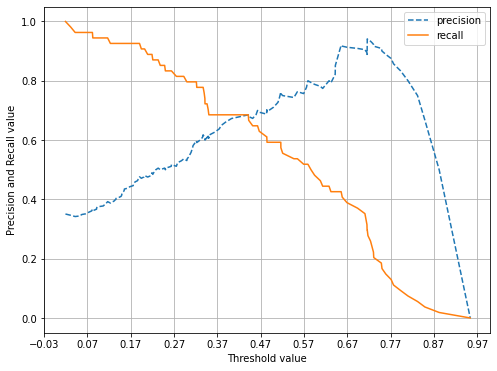

In [23]:
pred_proba_c1=lrclf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test,pred_proba_c1)

### Result
- 임곗값을 0.42정도로 낮추면 정밀도와 재현율이 어느정도 균형을 맞춤
- 그렇지만 지표의 값이 둘다 0.7로 낮은편

#### ▶ 데이터 값을 재점검

In [25]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Result
- min값이 0인 feature가 많음
- Ex. Glucose feature(포도당 수치)의 min값이 0이 되는 것은 말이 안됌

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

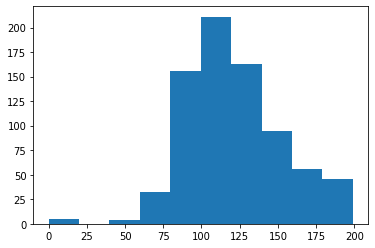

In [27]:
plt.hist(diabetes['Glucose'], bins=10)

#### min()값이 0인 feature에 대해 0값의 건수 및 비율 확인
- 확인 할 feature
    - Glucose
    - BloodPressure
    - SkinThickness
    - Insulin
    - BMI

In [28]:
# 0값을 검사할 feature명 list
zero_features=['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

In [29]:
# 전체 데이터 건수
total_count=diabetes['Glucose'].count()

In [32]:
# feature별로 반복하면서 data값이 0인 데이터 건수 추출, 퍼센트 계산
for feature in zero_features:
    zero_count=diabetes[diabetes[feature]==0][feature].count()
    print(feature,"0값을 가진 건수는 : ", zero_count, "   비율은 : ", (zero_count/total_count)*100)

Glucose 0값을 가진 건수는 :  5    비율은 :  0.6510416666666667
BloodPressure 0값을 가진 건수는 :  35    비율은 :  4.557291666666666
SkinThickness 0값을 가진 건수는 :  227    비율은 :  29.557291666666668
Insulin 0값을 가진 건수는 :  374    비율은 :  48.69791666666667
BMI 0값을 가진 건수는 :  11    비율은 :  1.4322916666666665


### Result
- SkiThickness, Insulin의 경우 0값이 매우 많음
- 이들은 일괄적으로 삭제하는 경우 전체 데이터가 많지 않기 때문에 학습하기가 어려움 
- feature의 0값을 평균값으로 대체해줄 것

In [34]:
# zero_features list 내부에 저장된 개별 feature들에 대해 0값을 평균값으로 대체
mean_zero_features=diabetes[zero_features].mean()
diabetes[zero_features]=diabetes[zero_features].replace(0,mean_zero_features)

## 3. Feature Scaling 
- feature를 평균 0, 분산 1로 변환
- 숫자 데이터에 적용

In [36]:
X=diabetes.iloc[:,:-1]
y=diabetes.iloc[:,-1]

In [37]:
# StandardScaler class 이용해서 feature dataset에 일괄적으로 스케일링 적용
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2, random_state=156, stratify=y)

In [39]:
# logistic Regression으로 학습, 예측 및 평가 수행
lrclf=LogisticRegression()
lrclf.fit(X_train,y_train)
pred=lrclf.predict(X_test)
pred_proba=lrclf.predict_proba(X_test)[:,1]

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
get_clf_eval(y_test, pred,pred_proba)

오차행렬: 
 [[90 10]
 [21 33]]
정확도:  0.7987012987012987 정밀도:  0.7674418604651163 재현율:  0.6111111111111112 f1:  0.6804123711340206 AUC:  0.8433333333333334


### Result
- data 변환과 스케일링 통해 성능 수치가 일정 수준 개선
- 그러나 여전히 재현율 수치 개선이 필요함

#### 임곗값을 0.3~0.5까지 변화시키면서 재현율과 다른 평가 지표 값 출력 

In [49]:
from sklearn.preprocessing import Binarizer
# get_eval_by_threshold()
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값', custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [50]:
thresholds=[0.3,0.33,0.36,0.39,0.42,0.45,0.48,0.50]
pred_proba=lrclf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값 0.3


ValueError: bad input shape ()